In [223]:
# Gaussian integration
import numpy as np
import scipy.integrate as integrate

def gauss(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2.*sigma**2))

limit1 = -0.92
limit2 = -limit1
integrate.quad( lambda x: gauss(x, 0,1), limit1, limit2 )[0]

0.6424272407712567

[43.         64.67993549 87.         12.8080834 ]
[0.39325144 2.14863122 9.70407449 0.39299895]
0.9692349972524302


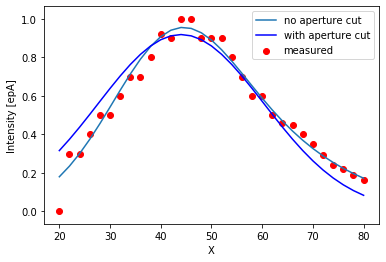

[16.41450768]
[0.55350003]
0.8840933070781464
Cut in command position = 35.8 +- 1.2


In [226]:
# Acceptance measurement
# Fit of angular spread as a function of position of collimator D1477

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

n3 = 1.8
n2 = n3*(4/2)**2 
n1 = n3*(8/2)**2 

table_scan = pd.read_csv("D1477_scan_3.54umC.txt", sep = '\t', header = None)        # Read table, assigns to database
X = table_scan.loc[:,0]
Y = table_scan.loc[:,1]

def gauss(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2.*sigma**2)) 

def func(x, mu1, mu2, mu3, sigma):
    return n1*gauss(x, mu1, sigma) + n2*gauss(x, mu2, sigma) + n3*gauss(x, mu3, sigma)

# Fit assuming no constraints due to JENSA apertures ------------------
popt, popv = curve_fit(func, X, Y, bounds = [(39, 64, 87, 0), (43, 69, 92, 50)])
Y_pred = func(X, *popt)

fig, ax = plt.subplots()
ax.scatter(X, Y, c = 'red', label="measured")               
ax.plot(X, Y_pred, label="no aperture cut")          

print(popt)
print(np.sqrt(np.diag(popv)))

# residual sum of squares
ss_res = np.sum((Y - Y_pred) ** 2)
# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

# Fit assuming constraints due to JENSA apertures ------------------
limitCommand = 0.92*1160.2/488.8 # This is the conversion from mrad sigma to limit in command position
                           # Cut at D1471 (distance = 488.8) and collimator at D1477 (distance = 1160.2)

def gaussLimited(x, mu, sigma):
    limit = sigmaPosition*limitCommand
    if hasattr(x, '__iter__'):
        return [0 if (xx<mu-limit or xx>mu+limit) else 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(xx-mu)**2/(2.*sigma**2)) for
                xx in x]
    else:
        return 0 if (x<mu-limit or x>mu+limit) else 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2.*sigma**2)) 

def funcLimited(x, sigma):
    mu1 = 44
    mu2 = 64
    mu3 = 87
    n3 = 1.8
    n2 = n3*(4/2)**2 
    n1 = n3*(8/2)**2 
    if hasattr(x, '__iter__'):
        return [n1*gaussLimited(xx, mu1, sigma) + n2*gaussLimited(xx, mu1, sigma) + n3*gaussLimited(xx, mu1, sigma) for xx in x]
    else:
        return n1*gaussLimited(x, mu1, sigma) + n2*gaussLimited(x, mu1, sigma) + n3*gaussLimited(x, mu1, sigma)
    
popt, popv = curve_fit(funcLimited, X, Y, bounds = [(6), (50)])
Y_pred = funcLimited(X, *popt)

ax.plot(X, Y_pred, c = 'blue', label="with aperture cut") 
ax.set_xlabel('X')
ax.set_ylabel('Intensity [epA]')
ax.legend()
plt.show()

print(popt)
print(np.sqrt(np.diag(popv)))

# residual sum of squares
ss_res = np.sum((Y - Y_pred) ** 2)
# total sum of squares
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)
print(r2)

# sigma cut seen at D1477
print('Cut in command position = {0:.1f} +- {1:.1f}'.format(popt[0]*limitCommand, np.sqrt(popv[0][0])*limitCommand))

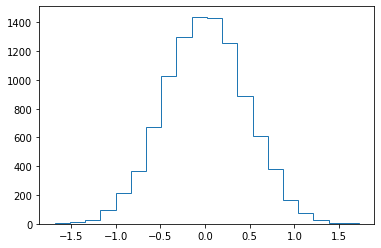

0.1240942028985507
0.4594853881479246


In [40]:
# Estimate energy spread combining different sources 
# All units in %

import matplotlib.pyplot as plt 
import numpy as np

# Incoming beam energy
sigma1 = 0.45  # Measured Si-detector ReA

# Energy spread due to foil
sigma2 = 0.00137/1.104*100 # 0.6um Al foil
#sigma2 = 0.00191/1.030*100 # 1.2um Al foil

# Detuning SECAR
mu = 0

num_samples = 10000
data = list()
for i in range(num_samples):
    data.append( np.random.normal(np.random.normal(np.random.uniform(-mu,mu),sigma1), sigma2) )
plt.hist(data, bins = 20, histtype = 'step')
plt.show()

print(sigma2)
print(np.array(data).std())

In [29]:
# Estimate of beam width based on intensity transmission though 1.5x1.5mm slits
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

intensity_transmitted = 0.22
uncertainty = 0.02 
center_slit_x = 0.36 #mm
center_slit_y = -0.37 #mm
slit_size = 1.5 #mm

def gauss(x, y, sigma_x, sigma_y, mu_x = 0, mu_y = 0):
    return 1/(2*np.pi*sigma_x*sigma_y)*np.exp(-(x-mu_x)**2/(2.*sigma_x**2)-(y-mu_y)**2/(2.*sigma_y**2))

sigma_xx = np.arange(0.1, 5, 0.1)
sigma_yy = np.arange(0.1, 5, 0.1)
sigma_x = []
sigma_y = []
transmi = []
n = 10

for i in sigma_xx:
    for j in sigma_yy:
        trans = integrate.dblquad( lambda y, x: gauss(x,y,i,j), center_slit_x-slit_size/2, 
                                          center_slit_x+slit_size/2, lambda x: center_slit_y-slit_size/2, 
                                          lambda x: center_slit_y+slit_size/2)[0] 
        if trans < intensity_transmitted +  uncertainty and trans > intensity_transmitted -  uncertainty:
            sigma_x.append(i)
            sigma_y.append(j)
            transmi.append(trans)

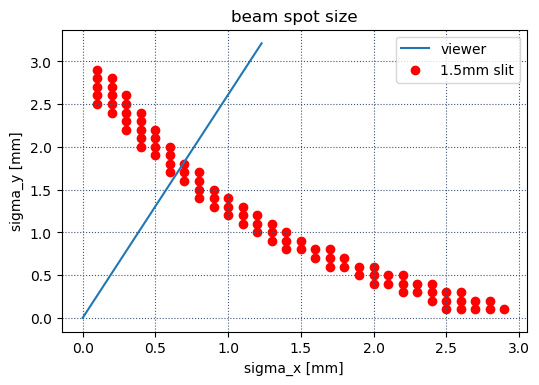

In [51]:
fig, ax = plt.subplots( dpi=100 )
ax.scatter(sigma_x, sigma_y, c = 'red', label = '1.5mm slit') 
ax.set_xlabel('sigma_x [mm]')
ax.set_ylabel('sigma_y [mm]')
ax.title.set_text('beam spot size')
ax.grid(b=True, which='major', color='#445577', linestyle=':')
ax.plot([0, 3*0.41], [0, 3*1.07], label = 'viewer')
ax.legend()
plt.show()